# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns;

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [3]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
display(df_transactions.head())
print(df_transactions.shape)
df_transactions['offer_id'].value_counts()
wine_camp = df_transactions.groupby('offer_id').sum()
pd.DataFrame(wine_camp)

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


(324, 3)


,n
offer_id,
1,10
2,10
3,6
4,12
5,4
6,12
7,19
8,20
9,10


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [4]:
#your turn
df = pd.merge(df_offers, df_transactions)
display(df.head())
matrix = df.pivot_table(index=['customer_name'], columns=['offer_id'], values='n')
matrix = matrix.fillna(0).reset_index()
display(matrix.head())
matrix.shape

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n
0,1,January,Malbec,72,56,France,False,Thomas,1
1,1,January,Malbec,72,56,France,False,Jackson,1
2,1,January,Malbec,72,56,France,False,Mitchell,1
3,1,January,Malbec,72,56,France,False,Peterson,1
4,1,January,Malbec,72,56,France,False,Wood,1


offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


(100, 33)

## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

SS should be small to give the best clustering - as this would be when most of the points are close to their cluster centroid - however we don't want too many independent clusters - so we pick the elbow point - where the SS starts to drop less significantly with every additional cluster centroid included.

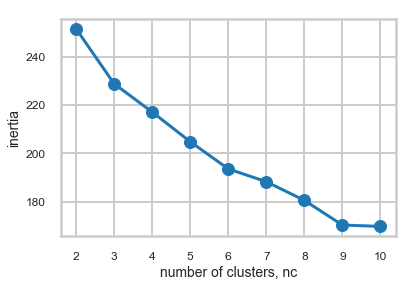

In [5]:
# your turn
# a list of the offer_ids
x_cols = matrix.columns[1:]

from sklearn.cluster import KMeans

ncs = range(2, 11)
inertias = []
for nc in ncs:
    model = KMeans(n_clusters=nc)
    model.fit(matrix[x_cols])
    inertias.append(model.inertia_)
    

plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)
# Plot ks vs inertias
plt.plot(ncs, inertias, '-o')
plt.xlabel('number of clusters, nc')
plt.ylabel('inertia')
plt.xticks(ncs)

plt.show()


In [6]:
cluster = KMeans(n_clusters=4)

matrix['cluster'] = cluster.fit_predict(matrix[matrix.columns[2:]])

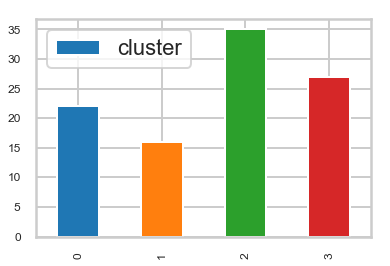

In [7]:
pd.DataFrame(matrix.cluster.value_counts().sort_index()).plot(kind='bar')
matrix.cluster.value_counts().sort_index().plot(kind='bar')

There are two aspects to this process that are difficult with this data. 

Firstly the 'elbow' isn't very pronounced, so it isn't clear how many clusters are naturally present in the data. There is a fairly linear reduction in the SS (sum of squared error) as we introduce additional clusters in to the model. 

Secondly due to the nature of KMean the intialization of the cluster centroids has a fairly large effect on which class the points are classified into. Therefore this model is relatively unstable - run it again and we end up with different numbers of members in each class. 

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

In [8]:
train_data = matrix[matrix.columns[2:-1]]
display(train_data.head())

offer_id,2,3,4,5,6,7,8,9,10,11,...,23,24,25,26,27,28,29,30,31,32
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [9]:
# Your turn.
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

In [10]:
def complex_silhouette_plot(cluster_range, train_data):
    cluster_sil_scores = pd.DataFrame(columns= ['n_clusters','ave_sil'])
    for n_clusters in cluster_range:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(15, 4)

        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(train_data) + (n_clusters + 1) * 10])

        clusterer = KMeans(n_clusters=n_clusters)
        cluster_labels = clusterer.fit_predict(train_data)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(train_data, cluster_labels)
        print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)
        cluster_sil_scores = cluster_sil_scores.append({'n_clusters': n_clusters, 'ave_sil': silhouette_avg}, ignore_index=True)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(train_data, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        plt.rc('font', size=12)          # controls default text sizes
        plt.rc('axes', titlesize=10)     # fontsize of the axes title
        plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
        plt.rc('xtick', labelsize=8)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=8)    # fontsize of the tick labels
        plt.rc('legend', fontsize=10)    # legend fontsize
        plt.rc('figure', titlesize=12)  # fontsize of the figure title

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        #ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(train_data.iloc[:, 0], train_data.iloc[:, 1], marker='.', s=40, lw=0, alpha=0.7, c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters), fontsize=10, fontweight='bold')
    plt.show()
    return cluster_sil_scores

For n_clusters = 2 The average silhouette_score is : 0.09467039888175721
For n_clusters = 3 The average silhouette_score is : 0.12001244567913955
For n_clusters = 4 The average silhouette_score is : 0.13592019936601107
For n_clusters = 5 The average silhouette_score is : 0.13627609943833938
For n_clusters = 6 The average silhouette_score is : 0.1170885304847323
For n_clusters = 7 The average silhouette_score is : 0.11720316225788743
For n_clusters = 8 The average silhouette_score is : 0.1452103398349456
For n_clusters = 9 The average silhouette_score is : 0.1350207798310356
For n_clusters = 10 The average silhouette_score is : 0.11332566248603314


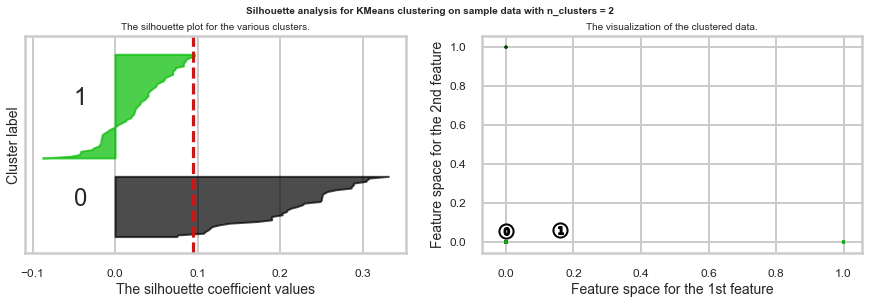

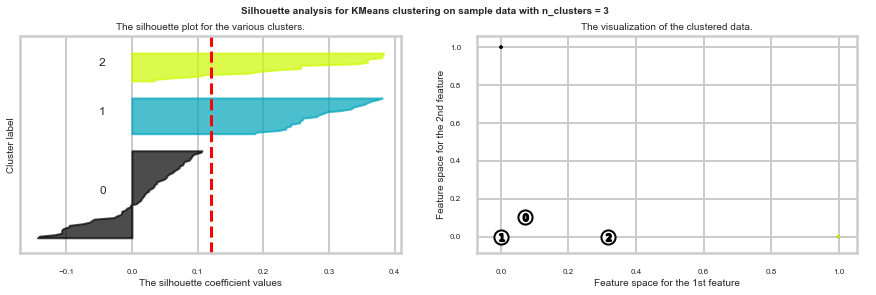

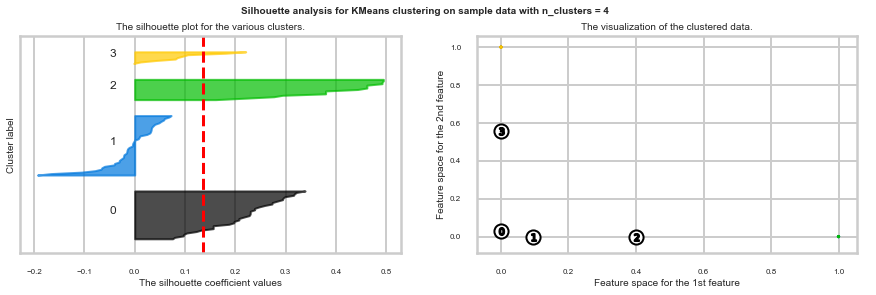

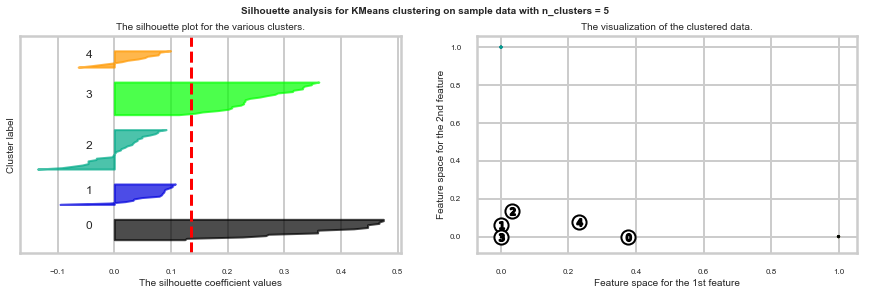

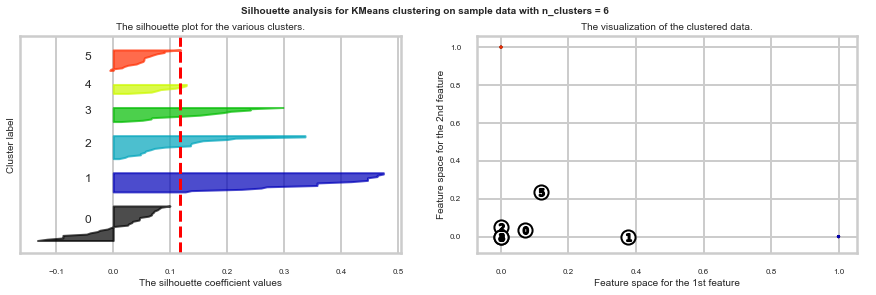

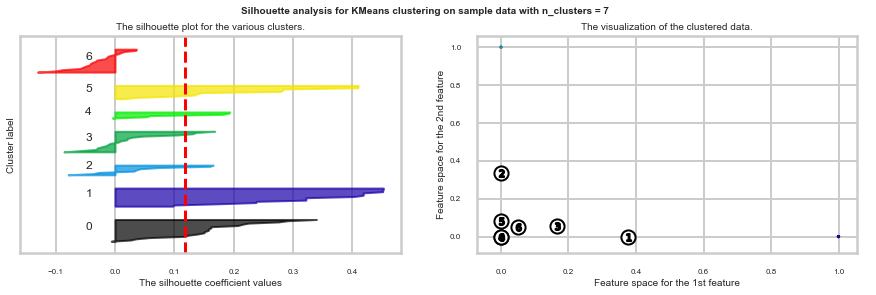

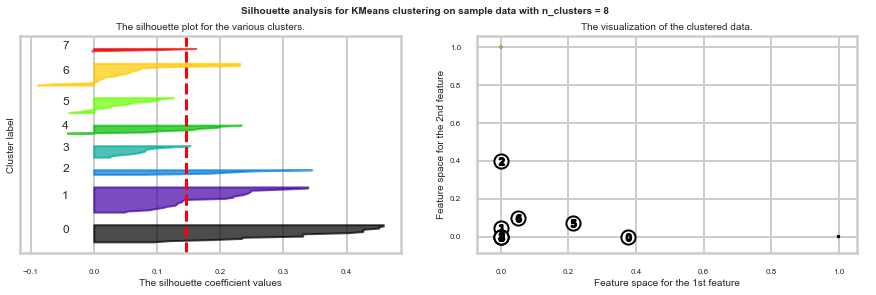

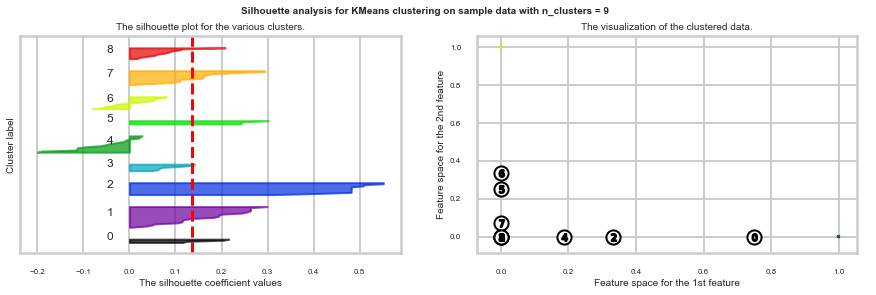

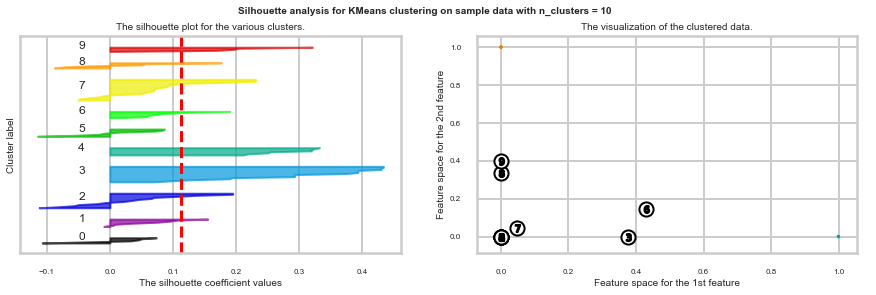

In [11]:
ncs = range(2, 11)
cluster_sil_scores = complex_silhouette_plot(ncs, train_data)

# This visualization needs to be done with PCA or otherwise processed data or you will see very little of the points - graphs repeated after PCA completed.

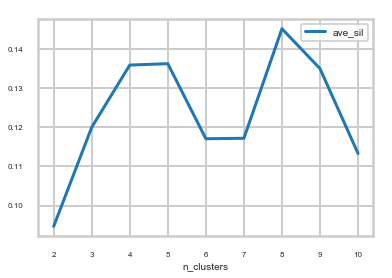

In [12]:
cluster_sil_scores.plot(kind='line', x = 'n_clusters', y='ave_sil')

No strong clustering structure was found in the data with the lowest silohette scores found with 6 and 9 clusters.

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [13]:
matrix.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,cluster
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2
1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3
2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2
4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


In [14]:
len(matrix['cluster'].unique())
#matrix['cluster'].astype('category')
# seaborn bug numerical labels for categories https://github.com/mwaskom/seaborn/issues/1515#issuecomment-408436200
col = ["r","b","g","y","c","m","k","gray"]
pal = col[:len(matrix['cluster'].unique())]

2.5913076354709614e-16


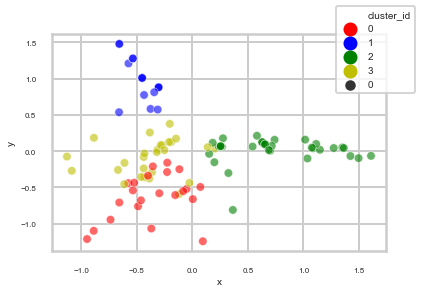

In [15]:
#your turn
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
model = PCA()

# Apply the fit_transform method of model to grains: pca_features
pca_features = model.fit_transform(train_data)

# Assign 0th column of pca_features: xs
xs = pca_features[:,0]

# Assign 1st column of pca_features: ys
ys = pca_features[:,1]

customer_clusters = pd.DataFrame({'customer_name': matrix['customer_name'], 'cluster_id':matrix['cluster'],
                                  'x':xs, 'y':ys})

ax = sns.scatterplot(x = 'x', y = 'y', data = customer_clusters, hue = customer_clusters['cluster_id'], 
                     palette=pal, size=0, alpha=0.6)
ax.legend(bbox_to_anchor=(1.1, 1.15))

# Calculate the Pearson correlation of xs and ys
correlation, pvalue = pearsonr(xs, ys)

# Display the correlation
print(correlation)

In [16]:
customer_clusters.head()

,customer_name,cluster_id,x,y
0,Adams,2,1.014908,0.157764
1,Allen,3,-0.313043,0.019268
2,Anderson,1,-0.451462,1.008114
3,Bailey,2,0.700551,0.006002
4,Baker,0,0.072574,-0.494352


What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

In [17]:
df_pca2 = pd.DataFrame(pca_features)
print(df_pca2.shape)
df_pca2.head()

(100, 31)


,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,1.014908,0.157764,-0.520468,0.060428,-0.241969,-0.196882,0.368429,0.520474,-0.274808,-0.085297,...,0.055042,-0.127366,-0.085673,-0.012280,-0.046452,0.029163,0.163629,0.061937,0.119970,0.014214
1,-0.313043,0.019268,-0.126521,-0.550758,0.033228,-0.079283,0.188643,-0.358709,-0.637473,0.665815,...,-0.246860,0.058895,-0.164822,0.085431,-0.095103,-0.146655,-0.057375,0.187154,0.189427,-0.161082
2,-0.451462,1.008114,0.281019,0.020699,0.031823,0.069687,0.062319,0.153356,0.203686,-0.106111,...,-0.005567,0.210114,0.049975,0.191391,-0.280153,0.107536,-0.128112,-0.311416,0.165438,0.018609
3,0.700551,0.006002,-0.056442,0.109981,-0.292657,0.563794,0.142397,0.082800,0.023687,0.228240,...,-0.009640,0.137732,-0.026826,-0.023919,0.045409,-0.094380,-0.028546,-0.056544,-0.081785,-0.049888
4,0.072574,-0.494352,0.835916,0.121361,-1.072569,0.058542,-0.436591,-0.184430,0.150530,0.011825,...,0.006481,-0.089306,-0.244866,0.139823,-0.050750,0.374359,0.182581,0.094053,0.097485,-0.006064


For n_clusters = 2 The average silhouette_score is : 0.09467039887348042
For n_clusters = 3 The average silhouette_score is : 0.12435687904899619
For n_clusters = 4 The average silhouette_score is : 0.14157962850261396
For n_clusters = 5 The average silhouette_score is : 0.1433373801987287
For n_clusters = 6 The average silhouette_score is : 0.1239310992619981
For n_clusters = 7 The average silhouette_score is : 0.1396953907426797
For n_clusters = 8 The average silhouette_score is : 0.11088844113272683
For n_clusters = 9 The average silhouette_score is : 0.11838496439376263
For n_clusters = 10 The average silhouette_score is : 0.1289223061251436


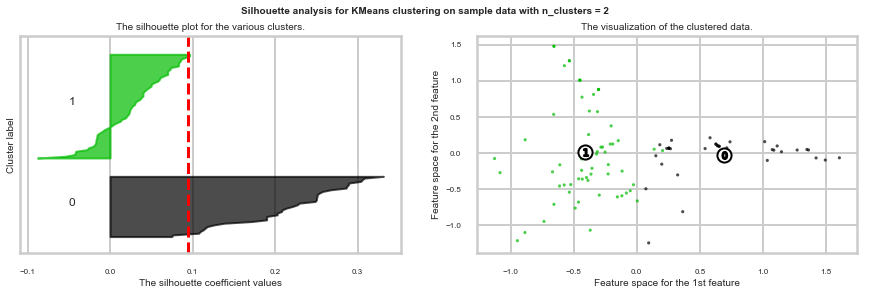

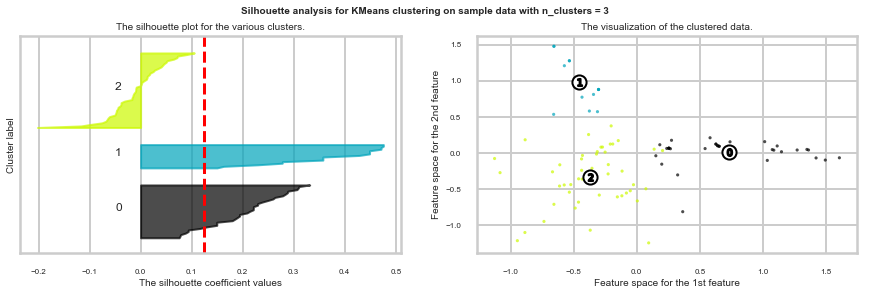

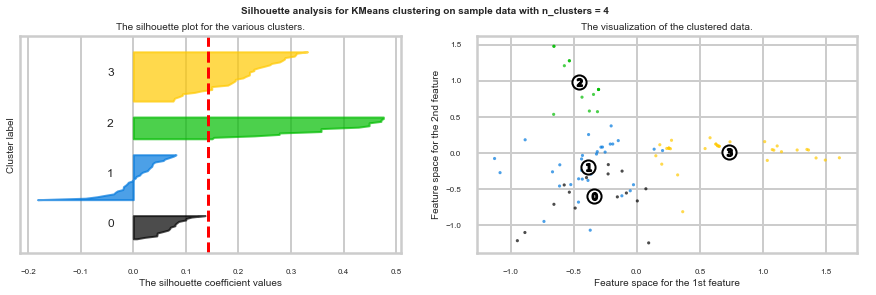

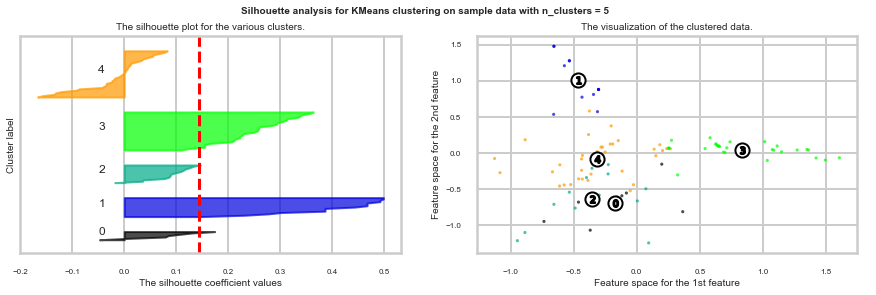

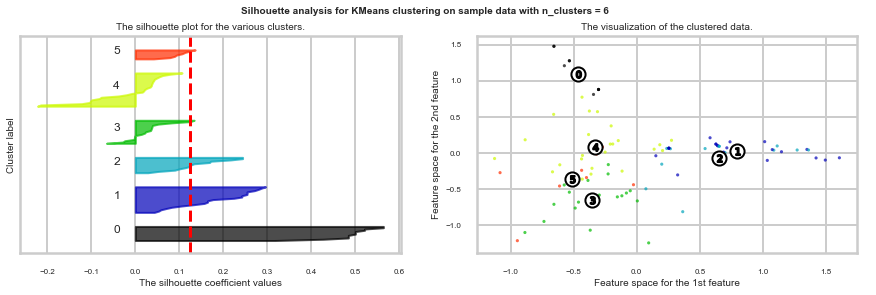

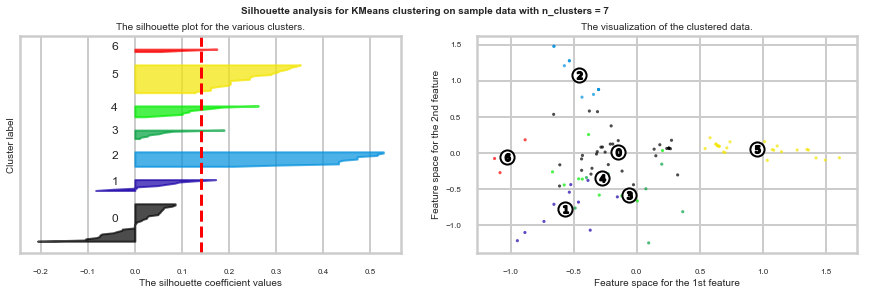

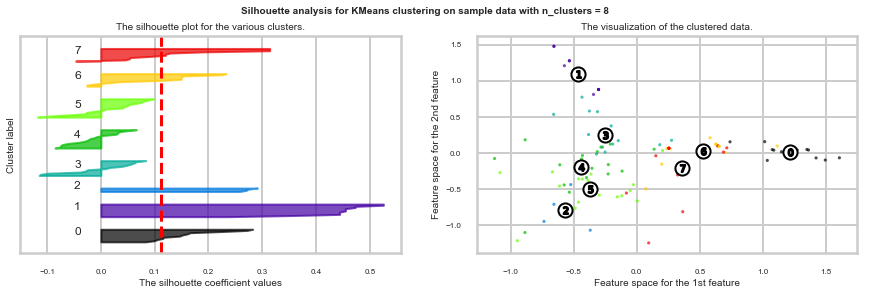

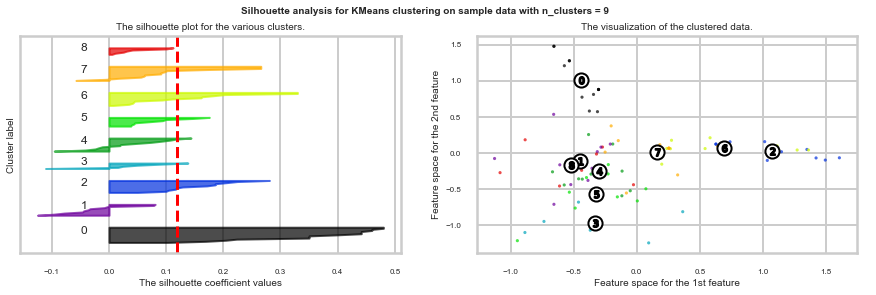

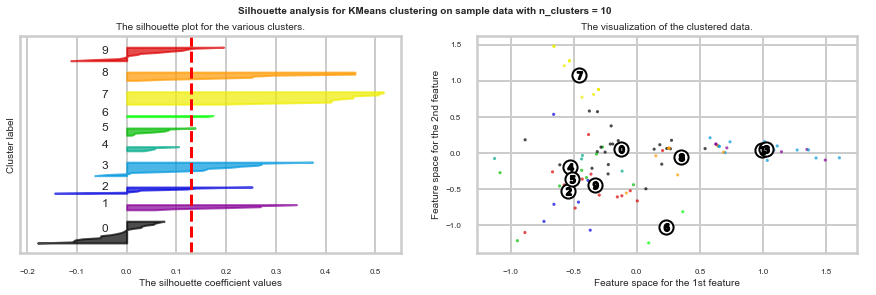

In [18]:
# repeating the Silhouette Plot with the full PCA matrix - so the visuliztion captures the 2 strongest dimentions
ncs = range(2, 11)
cluster_sil_scores = complex_silhouette_plot(ncs, df_pca2)

This data set is a great example of how categorization is not always easy to achieve. One category merges into the next without a clear boundary.
There are arguments for selecting 3,4,6 or 8 different categories based on the elbow and silhouette plots. 

Visualizations of the data needs to be done with the first 2 dimensions of the PCA transformed matrix so you can see the most variation possible on the 2 dimensions of a regular plot.

In [19]:
display(df.head())
df.shape

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n
0,1,January,Malbec,72,56,France,False,Thomas,1
1,1,January,Malbec,72,56,France,False,Jackson,1
2,1,January,Malbec,72,56,France,False,Mitchell,1
3,1,January,Malbec,72,56,France,False,Peterson,1
4,1,January,Malbec,72,56,France,False,Wood,1


(324, 9)

In [28]:
df = pd.merge(df_transactions, customer_clusters)
df = pd.merge(df_offers, df)
n =150
display(df.head(n).tail(10))
print(df.shape)
#display(df[(df['varietal'] == 'Champagne') & (df['cluster_id']==0)])
#df[(df['varietal'] == 'Champagne') & (df['cluster_id']==0)].shape

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n,cluster_id,x,y
140,14,June,Merlot,72,64,Chile,False,Reed,1,3,-0.271857,0.082994
141,14,June,Merlot,72,64,Chile,False,Wood,1,0,-0.398641,-0.339148
142,14,June,Merlot,72,64,Chile,False,Foster,1,3,-0.612324,-0.456194
143,15,June,Cabernet Sauvignon,144,19,Italy,False,Miller,1,0,-0.946940,-1.212323
144,15,June,Cabernet Sauvignon,144,19,Italy,False,Garcia,1,3,-0.319292,-0.013633
145,15,June,Cabernet Sauvignon,144,19,Italy,False,Jackson,1,3,-0.668236,-0.259736
146,15,June,Cabernet Sauvignon,144,19,Italy,False,Lopez,1,3,-0.610320,-0.162799
147,15,June,Cabernet Sauvignon,144,19,Italy,False,Young,1,0,-0.887020,-1.099328
148,15,June,Cabernet Sauvignon,144,19,Italy,False,Sanchez,1,3,-1.084257,-0.271163
149,16,June,Merlot,72,88,California,False,Thompson,1,3,0.138004,0.053530


(324, 12)


In [29]:
cl, cl_label = 0, 'is_0'
df[cl_label] = df.cluster_id==cl
display(df.groupby(cl_label)[['min_qty', 'discount']].mean())
grouped0 = df.groupby(cl_label).varietal.value_counts()
#grouped0.unstack(level=cl_label).fillna('')

,min_qty,discount
is_0,,
False,52.747826,56.965217
True,72.255319,65.638298


In [30]:
cl, cl_label = 1, 'is_1'
df[cl_label] = df.cluster_id==cl
display(df.groupby(cl_label)[['min_qty', 'discount']].mean())
grouped1 = df.groupby(cl_label).varietal.value_counts()
#grouped1.unstack(level=cl_label).fillna('')

,min_qty,discount
is_1,,
False,57.309609,60.608541
True,65.581395,52.116279


In [31]:
cl, cl_label = 2, 'is_2'
df[cl_label] = df.cluster_id==cl
display(df.groupby(cl_label)[['min_qty', 'discount']].mean())
grouped2 = df.groupby(cl_label).varietal.value_counts()
#grouped2.unstack(level=cl_label).fillna('')

,min_qty,discount
is_2,,
False,77.105263,61.372807
True,14.000000,54.989583


In [32]:
cl, cl_label = 3, 'is_3'
df[cl_label] = df.cluster_id==cl
display(df.groupby(cl_label)[['min_qty', 'discount']].mean())
grouped3 = df.groupby(cl_label).varietal.value_counts()
#grouped3.unstack(level=cl_label).fillna('')

,min_qty,discount
is_3,,
False,47.021459,58.755365
True,87.560440,61.340659


In [49]:
gf = pd.concat([grouped0,grouped1,grouped2, grouped3], axis=1, ).fillna('')
gf.columns = ['varietal_for_cluster_0', 'varietal_for_cluster_1', 'varietal_for_cluster_2', 'varietal_for_cluster_3']
gf.loc[[1],:]

varietal_for_cluster_0 varietal_for_cluster_1  \
True Cabernet Sauvignon                       9                          
     Champagne                               48                      1   
     Chardonnay                               3                      1   
     Espumante                                6                          
     Malbec                                   7                      1   
     Merlot                                   3                      1   
     Pinot Grigio                             1                          
     Pinot Noir                               1                     37   
     Prosecco                                16                      2   

                        varietal_for_cluster_2 varietal_for_cluster_3  
True Cabernet Sauvignon                      1                     22  
     Champagne                               5                     27  
     Chardonnay                                                    11  
     Espumante                              32                      2  
     Malbec                                 16                      8  
     Merlot                                  6                     10  
     Pinot Grigio                           16                         
     Pinot Noir                                                     6  
     Prosecco                               20                      5

It is interesting to dig into the groups and notice that customers who are members of cluster_1 almost exclusively purchase Pinot Noir! 

Members who like Cabernet Sauvignon, tend to be open to purchasing other wines also, as cluster 3 has most of those buys together many other wine type purchases - although no Pinot Grigio - Pinot Grigio offers are purchased by cluster 2 members together with Espumante, Malbec (lots of groups buy this wine type), and Prosecco!

The Champagne purchases tend to be cluster 0 member and will a fair amount of Prosecco as well as some other wines, they are the second largest Cab buyers - lots of bubbles for these people.

Cluster 2 members seem to be sensitive to purchase volume having the lowest min_vol mean, although they aren't always demanding a large discount. Cluster 3 purchasers on the other hand like to buy in bulk!

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

In [ ]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(train_data)

# Do the rest on your own :)
plt.plot(pca.explained_variance_)
plt.xlabel('$K$')
plt.xticks(range(0,33,1))
plt.xlim([0,31])
plt.ylabel('Explained Variance')
plt.title('Elbow Plot')

Based on this technique most variance is explained with 2,3 or 4 dimensions or features.

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [ ]:
# Your turn
from sklearn.cluster import AffinityPropagation, SpectralClustering, AgglomerativeClustering, DBSCAN
algorithms = ['AffinityPropagation', 'SpectralClustering', 'AgglomerativeClustering', 'DBSCAN']
algorithm_silscores = pd.Series(index=algorithms)

## Affinity Propagation

In [ ]:
damp_range = [0.5, 0.6, 0.7, 0.8, 0.9, 0.9999]
best_score = 0.0
for d in damp_range:
    
    # run clustering and predict labels
    clusterer = sklearn.cluster.AffinityPropagation( damping = d )
    cluster_labels = clusterer.fit_predict(train_data)
    
    # obtain and report silhouette scores
    slht_avg = silhouette_score(train_data, cluster_labels)
    print("For d = %.2f, the average silhouette score is %.4f." % (d, slht_avg))
    
    if slht_avg > best_score:
        best_score = slht_avg
        best_damping = d
        
print('Best damping parameter:', best_damping)
algorithm_silscores.loc['AffinityPropagation'] = best_score

## Spectral Clustering

In [ ]:
best_score = 0.0
for k in ncs:
    
    # run clustering and predict labels
    clusterer = sklearn.cluster.SpectralClustering(n_clusters = k)
    cluster_labels = clusterer.fit_predict(train_data)
    
    # obtain and report silhouette scores
    slht_avg = silhouette_score(train_data, cluster_labels)
    print("For k = %.0f, the average silhouette score is %.4f." % (k, slht_avg))
    
    if slht_avg > best_score:
        best_score = slht_avg
        best_k = k
        
print('Best k parameter:', best_k)
algorithm_silscores.loc['SpectralClustering'] = best_score

## Agglomerative Clustering

In [ ]:
best_score = 0.0
for k in ncs:
    
    # run clustering and predict labels
    clusterer = sklearn.cluster.AgglomerativeClustering(n_clusters = k)
    cluster_labels = clusterer.fit_predict(train_data)
    
    # obtain and report silhouette scores
    slht_avg = silhouette_score(train_data, cluster_labels)
    print("For k = %.0f, the average silhouette score is %.4f." % (k, slht_avg))
    
    if slht_avg > best_score:
        best_score = slht_avg
        best_k = k
        
print('Best k parameter:', best_k)
algorithm_silscores.loc['AgglomerativeClustering'] = best_score

## DBSCAN

In [ ]:
#find the best value for min_samples parameter. 
min_samples = [1, 2, 3]
best_score = 0.0

for min_sam in min_samples:
    
    # run clustering and predict labels
    clusterer = sklearn.cluster.DBSCAN(min_samples=min_sam)
    cluster_labels = clusterer.fit_predict(train_data)
    
    # obtain and report silhouette scores
    slht_avg = silhouette_score(train_data, cluster_labels)
    print("For min samples = %.0f, the average silhouette score is %.4f." % (min_sam, slht_avg))
    
    if slht_avg > best_score:
        best_score = slht_avg
        best_min_samples = min_sam
        
print('Best min_samples parameter:', best_min_samples)
algorithm_silscores.loc['DBSCAN'] = best_score

In [ ]:
print(algorithm_silscores)

None of the clustering models performed very well. Each model had a silhouette score < 0.2, meaning "No substantial structure was found." This makes sense, given that it was difficult to discern clear clusterings when we visualized the data. The clusterer that produced the highest silhouette score (0.19) was DBSCAN, however, this score should perhaps not even be counted because it was obtained using min_samples = 1, meaning that it could create neighborhoods/clusters containing only one sample.